## Imports

In [1]:
import tensorflow as tf
from glob import glob
from os.path import join
from tensorflow.keras import layers, models
import xarray as xr
import pandas as pd
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import imports.GDL_layers as GDL_layers
from imports.GDL_model import gdl_model
from imports.GDL_model import CNN_model

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

2023-01-01 13:55:58.641134: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load data

In [2]:
# Load data
train_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/semifixed_train_data.nc")
validation_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/semifixed_validation_data.nc")
test_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/semifixed_test_data.nc")

In [3]:
input_train = train_ds['ellipse'].expand_dims(dim='channel', axis=-1)
input_train['p'] = np.arange(input_train['p'].shape[0])
output_train = train_ds[['maj_len', 'min_len']].to_array().transpose()
output_train['p'] = np.arange(output_train['p'].shape[0])
input_val = validation_ds['ellipse'].expand_dims(dim='channel', axis=-1)
input_val['p'] = np.arange(input_val['p'].shape[0])
output_val = validation_ds[['maj_len', 'min_len']].to_array().transpose()
output_val['p'] = np.arange(output_val['p'].shape[0])
input_test = test_ds['ellipse'].expand_dims(dim='channel', axis=-1)
input_test['p'] = np.arange(input_test['p'].shape[0])
output_test = test_ds[['maj_len', 'min_len']].to_array().transpose()
output_test['p'] = np.arange(output_test['p'].shape[0])

In [4]:
# Normalize the output data
output_scale_stats = pd.DataFrame(index=range(output_train.shape[-1]), columns=["mean", "sd"])
output_scale_stats.loc[:, "mean"] = output_train.mean(dim="p")
output_scale_stats.loc[:, "sd"] = output_train.std(dim="p")
output_train_norm = xr.DataArray(coords=output_train.coords, dims=output_train.dims)
output_val_norm = xr.DataArray(coords=output_val.coords, dims=output_val.dims)
output_test_norm = xr.DataArray(coords=output_test.coords, dims=output_test.dims)
for i in range(output_train.shape[-1]):
    output_train_norm[:, i] = (output_train[:, i] - output_scale_stats.loc[i, "mean"]) / output_scale_stats.loc[i, "sd"]
    output_val_norm[:, i] = (output_val[:, i] - output_scale_stats.loc[i, "mean"]) / output_scale_stats.loc[i, "sd"]
    output_test_norm[:, i] = (output_test[:, i] - output_scale_stats.loc[i, "mean"]) / output_scale_stats.loc[i, "sd"]

In [5]:
def aug_da(da, concat_dim='p', rot=True):
    length = da[concat_dim].shape[0]
    aug_da = xr.concat([da]*4, dim=concat_dim)
    if rot:
        for k in range(4):
            aug_da.values[k*length:(k+1)*length] = np.rot90(aug_da.values[k*length:(k+1)*length], axes=(1, 2), k=k)
    aug_da[concat_dim] = np.arange(aug_da[concat_dim].shape[0])
    return aug_da

In [6]:
aug_input_train = aug_da(input_train)
aug_output_train_norm = aug_da(output_train_norm, rot=False)

## Train Models

In [7]:
model_params = {
    'filters': [32, 32, 64, 64, 128],
    'kernel_sizes': [3, 3, 3, 3, 3],
    'conv_2d_activation': 'relu',
    'pool_sizes': [2, 2, 2, 2, 1],
    'dense_activation': 'relu',
    'optimizer': 'nadam',
    'metrics': [],
    'verbose': 1,
}

In [8]:
cnn_model = CNN_model(**model_params)
aug_cnn_model = CNN_model(**model_params)
ricnn_model = gdl_model(rot_inv=5, **model_params)

In [9]:
cnn_model.fit(input_train, output_train_norm, xv=input_val, yv=output_val_norm)
aug_cnn_model.fit(aug_input_train, aug_output_train_norm, xv=input_val, yv=output_val_norm)
ricnn_model.fit(input_train, output_train_norm, xv=input_val, yv=output_val_norm)

2022-12-22 11:38:06.975788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 11:38:07.623117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


Epoch 1/10


2022-12-22 11:38:09.470448: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


313/313 [==============================] - 7s 14ms/step - loss: 0.6889 - val_loss: 0.3032
Epoch 2/10
313/313 [==============================] - 4s 14ms/step - loss: 0.3043 - val_loss: 0.1693
Epoch 3/10
313/313 [==============================] - 4s 13ms/step - loss: 0.1276 - val_loss: 0.0501
Epoch 4/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0597 - val_loss: 0.1185
Epoch 5/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0442 - val_loss: 0.0423
Epoch 6/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0341 - val_loss: 0.0170
Epoch 7/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0296 - val_loss: 0.0143
Epoch 8/10
313/313 [==============================] - 5s 15ms/step - loss: 0.0253 - val_loss: 0.0150
Epoch 9/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0224 - val_loss: 0.0133
Epoch 10/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0205 - val_loss: 0.0158


{'loss': [0.5232529640197754,
  0.09692907333374023,
  0.04923607409000397,
  0.033330101519823074,
  0.021965250372886658,
  0.017985036596655846,
  0.014375430531799793,
  0.012312631122767925,
  0.011933651752769947,
  0.011503309942781925],
 'val_loss': [0.1479538530111313,
  0.060200076550245285,
  0.029907818883657455,
  0.028290923684835434,
  0.014761658385396004,
  0.020398998633027077,
  0.014162625186145306,
  0.008592268452048302,
  0.00942892488092184,
  0.008462905883789062]}

In [16]:
cnn_model.model.save("saved_models/strict_vs_approx_inv/cnn_model")
aug_cnn_model.model.save("saved_models/strict_vs_approx_inv/aug_cnn_model")
ricnn_model.model.save("saved_models/strict_vs_approx_inv/ricnn_model")

INFO:tensorflow:Assets written to: saved_models/strict_vs_approx_inv/cnn_model/assets


INFO:tensorflow:Assets written to: saved_models/strict_vs_approx_inv/cnn_model/assets


INFO:tensorflow:Assets written to: saved_models/strict_vs_approx_inv/aug_cnn_model/assets


INFO:tensorflow:Assets written to: saved_models/strict_vs_approx_inv/aug_cnn_model/assets


INFO:tensorflow:Assets written to: saved_models/strict_vs_approx_inv/ricnn_model/assets


INFO:tensorflow:Assets written to: saved_models/strict_vs_approx_inv/ricnn_model/assets


## Test Rotational Invariance

In [7]:
cnn_model = tf.keras.models.load_model("saved_models/strict_vs_approx_inv/cnn_model")
aug_cnn_model = tf.keras.models.load_model("saved_models/strict_vs_approx_inv/aug_cnn_model")
ricnn_model = tf.keras.models.load_model("saved_models/strict_vs_approx_inv/ricnn_model")

2023-01-01 13:56:29.633816: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-01 13:56:29.633869: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc62): /proc/driver/nvidia/version does not exist
2023-01-01 13:56:29.636798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
def un_norm(x, scale_stats):
    new_x = np.empty(x.shape)
    for i in range(new_x.shape[-1]):
        new_x[:, i] = (x[:, i] * scale_stats.loc[i, "sd"]) + scale_stats.loc[i, "mean"]
    return new_x

In [9]:
rng = np.random.default_rng()
x = np.arange(0, 128)
y = np.arange(0, 128)[:, None]

In [10]:
maj_len = 25 # rng.uniform(10.0, 40.0)
min_len = 10 # rng.uniform(1.0, maj_len/1.5)
rot_ang = np.pi/6 # rng.uniform(0, np.pi)
dist = 30
pos_angs = np.linspace(0, 2*np.pi, 365, endpoint=False)
ellipses_raw = []
for pos_ang in pos_angs:
    (x0, y0) = (63 + dist*np.cos(-pos_ang), 63 + dist*np.sin(-pos_ang)) # rng.uniform(20.0, 108, 2)
    ang = -rot_ang - pos_ang
    ellipse = (
        (((x - x0)*np.cos(ang) + (y - y0)*np.sin(ang)) / (maj_len/2))**2
        + (((x - x0)*np.sin(ang) - (y - y0)*np.cos(ang)) / (min_len/2))**2
        <= 1
    )
    ellipse = xr.DataArray(
        np.exp(-0.1*nd.distance_transform_edt(1 - ellipse)),
        dims=("x", "y"),
        coords={"x": x, "y": x}
    )
    ellipses_raw.append(ellipse.expand_dims("channel", axis=-1))
ellipses = xr.concat(ellipses_raw, dim="p")

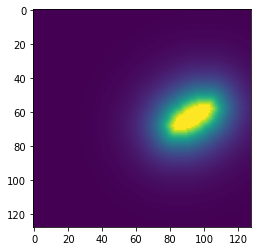

In [22]:
plt.imshow(ellipses[0, :, :, 0])

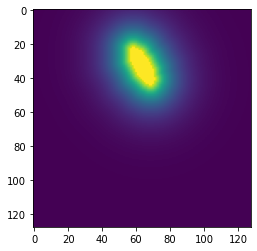

In [23]:
plt.imshow(ellipses[90, :, :, 0])

In [7]:
cnn_preds = cnn_model.predict(ellipses)
aug_cnn_preds = aug_cnn_model.predict(ellipses)
ricnn_preds = ricnn_model.predict(ellipses)

12/12 [==============================] - 6s 495ms/step


In [8]:
print(cnn_preds[:, 0].var())
print(aug_cnn_preds[:, 0].var())
print(ricnn_preds[:, 0].var())

0.23513499
0.0037851485
0.0049686306


In [9]:
print(cnn_preds[:, 1].var())
print(aug_cnn_preds[:, 1].var())
print(ricnn_preds[:, 1].var())

0.2414021
0.0023072225
0.002283389


In [10]:
maj_len = 25 # rng.uniform(10.0, 40.0)
min_len = 10 # rng.uniform(1.0, maj_len/1.5)
rot_angs = np.linspace(0, 2*np.pi, 365, endpoint=False)
dist = 30
pos_ang = 0 
ellipses_raw = []
for rot_ang in rot_angs:
    (x0, y0) = (63 + dist*np.cos(-pos_ang), 63 + dist*np.sin(-pos_ang)) # rng.uniform(20.0, 108, 2)
    ang = -rot_ang - pos_ang
    ellipse = (
        (((x - x0)*np.cos(ang) + (y - y0)*np.sin(ang)) / (maj_len/2))**2
        + (((x - x0)*np.sin(ang) - (y - y0)*np.cos(ang)) / (min_len/2))**2
        <= 1
    )
    ellipse = xr.DataArray(
        np.exp(-0.1*nd.distance_transform_edt(1 - ellipse)),
        dims=("x", "y"),
        coords={"x": x, "y": x}
    )
    ellipses_raw.append(ellipse.expand_dims("channel", axis=-1))
ellipses = xr.concat(ellipses_raw, dim="p")

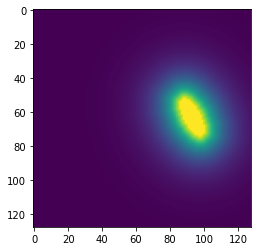

In [18]:
plt.imshow(ellipses[120, :, :, 0])

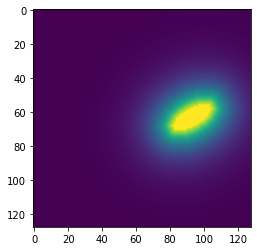

In [20]:
plt.imshow(ellipses[30, :, :, 0])

In [13]:
cnn_preds = cnn_model.predict(ellipses)
aug_cnn_preds = aug_cnn_model.predict(ellipses)
ricnn_preds = ricnn_model.predict(ellipses)

12/12 [==============================] - 6s 468ms/step


In [15]:
print(cnn_preds[:, 0].var())
print(aug_cnn_preds[:, 0].var())
print(ricnn_preds[:, 0].var())

0.20886432
0.0027709869
0.00407316


In [14]:
print(cnn_preds[:, 1].var())
print(aug_cnn_preds[:, 1].var())
print(ricnn_preds[:, 1].var())

0.31524417
0.0027688157
0.002166086


In [11]:
base_image = ellipses[0:1].values

In [12]:
rot_image = np.rot90(base_image, axes=(1, 2), k=1)

In [13]:
print(un_norm(aug_cnn_model.predict(base_image), output_scale_stats))
print(un_norm(aug_cnn_model.predict(rot_image), output_scale_stats))
print(un_norm(ricnn_model.predict(base_image), output_scale_stats))
print(un_norm(ricnn_model.predict(rot_image), output_scale_stats))

1/1 [==============================] - 0s 199ms/step
[[24.57552719 10.42027283]]
1/1 [==============================] - 0s 17ms/step
[[25.44377518 10.00481415]]
1/1 [==============================] - 0s 247ms/step
[[23.98227692  9.85518742]]
1/1 [==============================] - 0s 28ms/step
[[23.98227692  9.85518742]]


In [15]:
aug_cnn_model.predict(base_image)

1/1 [==============================] - 0s 27ms/step


array([[-0.06312828,  0.29384595]], dtype=float32)